In [1]:
from __future__ import (division, print_function)

In [2]:
%autoreload 2
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd
import h5py
import cPickle
from scipy.spatial import KDTree
#import seaborn as sns
#sns.set_style('white')

In [5]:
import statsmodels as sm

In [6]:
import sys
sys.path.append("../")
import extract_catalog as ec
import plot_gal_prop as plotg
import plot_DM_prop as plotDM
import get_DM_centroids as getDM
import get_gal_centroids as getgal
import get_KDE 

In [7]:
partDMfile = "../../data/Illustris-1_" + \
    "00135_APillepich_KarenNG_ParticleData_Group_PartType1.h5"

data_f = h5py.File("../../data/Illustris-1_fof_subhalo" +
                   "_myCompleteHaloCatalog_00135.hdf5")

In [8]:
partDM = h5py.File(partDMfile)

In [9]:
part_halos = h5py.File("../../data/DM_particles_clst_loc.h5")
haloEndIx = part_halos["loc"][...]

In [34]:
fhat_stars = cPickle.load(open("../../data/fhat_I_lum.pkl", "r"))

In [35]:
clstNo = 13 #range(129)
threshold = 0.3

In [36]:
matches = {}

In [37]:
%time coord_dict = ec.get_DM_particles([clstNo], partDM, dataPath="../../data/")

CPU times: user 1.03 s, sys: 646 ms, total: 1.68 s
Wall time: 1.67 s


In [38]:
clst_df = ec.extract_clst(data_f, clstNo)
BCG_ix = getgal.get_BCG_ix(clst_df)

In [39]:
np.array(clst_df[["SubhaloPos1", "SubhaloPos2"]]).shape

(3734, 2)

In [40]:
BCG_ix

1

# the first halo id is 1 ..... different than other index scheme

In [41]:
%time fhat = getDM.make_histogram_with_2kpc_resolution(coord_dict[clstNo])

CPU times: user 39.8 s, sys: 1.22 s, total: 41 s
Wall time: 40.7 s


In [113]:
coord_dict[13]["coords"][:, :2]

array([[ 2330.6953125 ,  1234.953125  ],
       [ 2329.890625  ,  1235.8203125 ],
       [ 2329.11523438,  1235.171875  ],
       ..., 
       [ 1382.83789062,  1132.828125  ],
       [ 1378.63867188,  1130.609375  ],
       [ 1392.75195312,  1130.9375    ]], dtype=float32)

have a background count threshold on the density

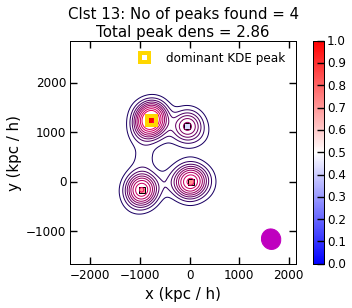

In [42]:
plt.figure(figsize=(25, 25))
plotg.plot_KDE_peaks(fhat_stars[clstNo], clstNo=clstNo)

In [43]:
fhat["log_est"] = np.log(fhat["estimate"])

Converting unit of kpc / h to kpc for galaxy data
CPU times: user 18.9 s, sys: 331 ms, total: 19.2 s
Wall time: 19.2 s


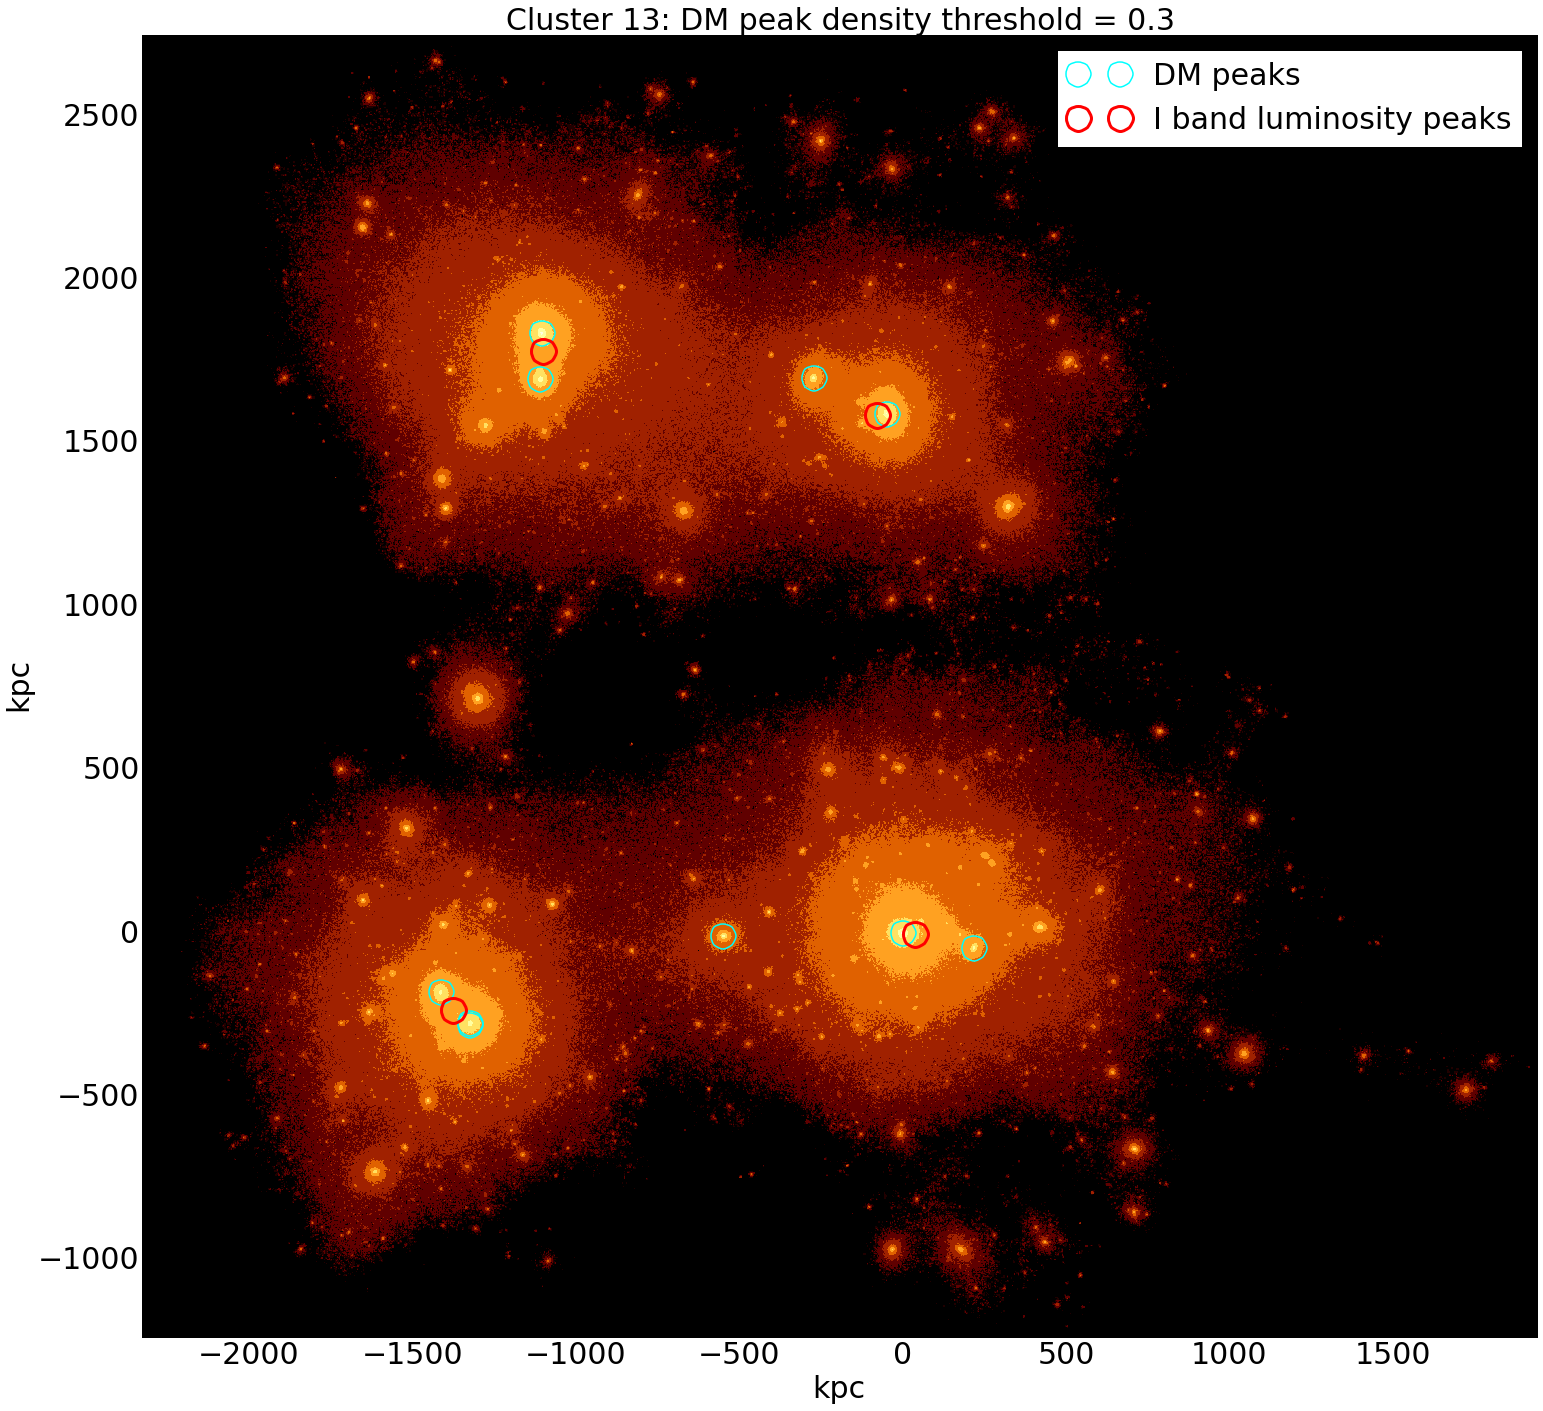

In [44]:
plt.figure(figsize=(25, 25))
%time plotDM.plot_DM_fhat(fhat, fhat_stars[clstNo], clstNo, threshold=threshold)

In [45]:
matches[clstNo] = {}

In [46]:
matches[clstNo]["dist"], matches[clstNo]["match_ix"] = \
    getDM.match_DM_peaks_with_gal_peaks(fhat, fhat_stars[clstNo], 
                                        threshold=threshold)

Converting subhalo distance units from kpc / h to kpc


In [47]:
uncertainty = np.sqrt(fhat_stars[clstNo]["bandwidth_matrix_H"])
err = np.sqrt(uncertainty[0, 0] ** 2. + uncertainty[1, 1])

In [48]:
print("offset = {0:.2f} +/- {1:.2f} kpc".format(matches[clstNo]["dist"][0], 
                                            err + 2))

offset = 57.55 +/- 197.75 kpc


find offset from BCG

In [49]:
peaks_mask = fhat["peaks_dens"] > threshold

In [50]:
BCG_offsets = \
    np.sqrt(fhat["peaks_xcoords"][peaks_mask]**2 + 
            fhat["peaks_ycoords"][peaks_mask]**2)

In [51]:
np.sort(BCG_offsets)[:2]

array([   1.34095621,  221.09367371], dtype=float32)

In [52]:
galTree = getgal.get_gal_coords(clst_df)

In [53]:
peak_coords = np.array([fhat["peaks_xcoords"][peaks_mask],
                       fhat["peaks_ycoords"][peaks_mask]]).transpose()

In [54]:
len(peak_coords)

10

In [55]:
fhat.keys()

['peaks_colIx',
 'log_est',
 'peaks_rowIx',
 'peaks_ycoords',
 'peaks_dens',
 'estimate',
 'eval_points',
 'peaks_xcoords']

In [102]:
fhat["eval_points"][0] = \
    fhat["eval_points"][0].reshape(1, fhat["eval_points"][0].shape[0])

In [105]:
fhat["eval_points"][0].shape

(1, 2135)

In [103]:
fhat["eval_points"][1] = \
    fhat["eval_points"][1].reshape(1, fhat["eval_points"][1].shape[0])

In [104]:
fhat["eval_points"][1].shape

(1, 1993)

In [109]:
np.sum(fhat["estimate"] > 0)

1900496

In [98]:
np.vstack(fhat["eval"])

array([-2329.69506836, -2327.69482422, -2325.69458008, ...,  2746.8972168 ,
        2748.89770508,  2750.89819336], dtype=float32)

In [ ]:
%time KDE_fhat = get_KDE.do_KDE_and_get_peaks(coord_dict[13]["coords"][:, :2])